In [1]:
# Load all the tools
import numpy as np
# from wisdem.aeroelasticse.CaseLibrary import ROSCO_Test
import os

from weis.aeroelasticse.FAST_reader import InputReader_Common, InputReader_OpenFAST, InputReader_FAST7
from weis.aeroelasticse.FAST_writer import InputWriter_Common, InputWriter_OpenFAST, InputWriter_FAST7
from weis.aeroelasticse.runFAST_pywrapper import runFAST_pywrapper_batch
from weis.aeroelasticse.CaseGen_General import CaseGen_General
from weis.aeroelasticse.CaseGen_IEC import CaseGen_IEC
from pCrunch import pdTools
from pCrunch import Processing, Analysis
from weis.aeroelasticse.Util import FileTools
# Instantiate fast_IO
from ROSCO_toolbox import utilities as ROSCO_utilities
fast_io = ROSCO_utilities.FAST_IO()
fast_pl = ROSCO_utilities.FAST_Plots()
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

# Test Results Directory
Select `test_case`

In [47]:
test_case = 'c_fl_phase'


if test_case == 'no_mass':
    test_dir = [
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/no_mass'
               ]
    
elif test_case == 'wave_dir':
    test_dir = [
            '/Users/dzalkind/Tools/WEIS-1/results/NASA/no_mass'
           ]
    
elif test_case == 'sweep_wn':
    test_dir = [
        '/Users/dzalkind/Tools/WEIS-1/results/NASA/sweep_wn'
    ]
    
elif test_case == 'const_wn':
    test_dir = [
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/no_mass',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/const_wn'
    ]

elif test_case == 'ideal_wn':
    test_dir = [
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/no_mass',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/const_wn',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/ideal_wn'
    ]

elif test_case == 'controlled_wn':
    test_dir = [
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/no_mass',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/const_wn',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/ideal_wn',
                '/Users/dzalkind/Tools/WEIS-1/results/NASA/controlled_wn'
    ]
    
elif test_case == 'c_pitch':
    test_dir = [
        '/Users/dzalkind/Tools/WEIS-1/results/NASA/c_pitch'
    ]
    
elif test_case == 'c_peakshave':
    test_dir = [
        '/Users/dzalkind/Tools/WEIS-1/results/NASA/c_peakshave'
    ]
    
elif test_case == 'c_fl_phase':
    test_dir = [
        '/Users/dzalkind/Tools/WEIS-1/results/NASA/c_fl_phase'
    ]
    
elif test_case == 'c_fl_gain':
    test_dir = [
        '/Users/dzalkind/Tools/WEIS-1/results/NASA/c_fl_gain'
    ]

# name_base  = 'dataset1'

In [48]:
# Load case matrix into dataframe
case_matrix = [None] * len(test_dir)
cm   = [None] * len(test_dir)
fastFile  = [None] * len(test_dir)
fastRead  = [None] * len(test_dir)

for i, dir in enumerate(test_dir):
    case_matrix[i] = FileTools.load_yaml(os.path.join(test_dir[i],'case_matrix.yaml'), package=1)
    cm[i] = pd.DataFrame(case_matrix[i])

    # Get ALL FAST info
#     fastRead[i] = InputReader_OpenFAST(FAST_ver='OpenFAST', dev_branch=True)
#     fastFile[i] = os.path.join(test_dir[i],cm[i]['Case_Name'][0] + '.fst')
#     fastRead[i].FAST_InputFile = os.path.basename(fastFile[i])   # FAST input file (ext=.fst)
#     fastRead[i].FAST_directory = os.path.dirname(fastFile[i])   # Path to fst directory files
#     fastRead[i].execute()



In [49]:
if test_case in ['no_mass','wave_dir','const_wn','ideal_wn'] :
    inds = [
            ('IEC','DLC'),
    ]
    
elif 'sweep_wn' in test_case:
    inds = [
        ('HydroDyn','omega_TMD')
    ]
elif 'fl_phase' in test_case:
    inds = [
        ('meta', 'phase_30'),
        ('DISCON_in', 'F_FlCornerFreq'),
#         ('DISCON_in', 'F_FlHighPassFreq'),
        ('DISCON_in', 'Fl_Kp'),
    ]

elif 'fl_gain' in test_case:
    inds = [
#         ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp'),
    ]
elif 'peakshave' in test_case:
    inds = [
        ('meta', 'ps_perc')
    ]
elif 'pitch' in test_case:
    inds = [
        ('meta', 'omega')
    ]
else:
    print('WARNING: your test_case is messed up')

cm[0][inds]
# inds


,"(meta, phase_30)","(DISCON_in, F_FlCornerFreq)","(DISCON_in, Fl_Kp)"
0,-76.357,0.02,-250.035
1,-65.641,0.04,-67.141
2,-55.295,0.06,-33.272
3,-45.456,0.08,-21.418
4,-36.221,0.10,-15.931
...,...,...,...
315,26.324,0.32,-7.130
316,29.468,0.34,-7.021
317,32.354,0.36,-6.930
318,35.010,0.38,-6.852


In [50]:
# Set up pCrunch, run if not already
reCrunch = False

name_base = 'dataset1'
    
# Do stats yaml exist?
stat_yaml_there = [os.path.exists(os.path.join(test,'stats',name_base + '_stats.yaml')) for test in test_dir]

outfiles = [[os.path.join(test, cn + '.outb') for cn in cm[i_test].Case_Name] for i_test, test in enumerate(test_dir)]


fp = [None]*len(test_dir)
st = [None]*len(test_dir)
lr = [None]*len(test_dir)
stats = [None]*len(test_dir)
load_rankings = [None]*len(test_dir)
# Load and save statistics and load rankings
for i_test, test in enumerate(test_dir):
    if not stat_yaml_there[i_test] or reCrunch:

        # Set some processing parameters
        fp[i_test] = Processing.FAST_Processing()
        fp[i_test].results_dir              = os.path.join(test, 'stats')
        fp[i_test].OpenFAST_outfile_list    = outfiles[i_test]
        fp[i_test].t0                       = 200         
        fp[i_test].parallel_analysis        = True
        fp[i_test].parallel_cores           = 8
    #     fp[i_test].DEL_info = [('TwrBsMyt', 4)]#, ('RootMyb2', 10), ('RootMyb3', 10)]


        fp[i_test].verbose                  = True
        fp[i_test].save_LoadRanking         = True
        fp[i_test].save_SummaryStats        = True
        
        fp[i_test].ranking_vars.append(['GenPwr']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['TwrBsMyt']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['TwrBsMxt']), fp[i_test].ranking_stats.append('max')
        fp[i_test].ranking_vars.append(['NcIMUTAxs']), fp[i_test].ranking_stats.append('std')
        fp[i_test].ranking_vars.append(['NcIMUTAys']), fp[i_test].ranking_stats.append('std')
        fp[i_test].channels_magnitude = {'TwrBsM': ['TwrBsMyt','TwrBsMxt']}

        stats[i_test], load_rankings[i_test] = fp[i_test].batch_processing()
        
    # re-load to get rid of dataset
    stats[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_stats.yaml'), package=1)
    load_rankings[i_test] = FileTools.load_yaml(os.path.join(os.path.join(test, 'stats'),name_base+'_LoadRanking.yaml'), package=1)

    # Turn into dataframe
    st[i_test] = pdTools.dict2df(stats[i_test])
    lr[i_test] = pdTools.dict2df(load_rankings[i_test])
    
    
# if len(test_dir) > 1:
#     st.index = st['dataset_0']['meta']['name']
#     cm[0].index = cm[0]['Case_Name']
#     cm0 = cm[0]   # use only cm[0] and assume all cases are same
# else:
#     st.index = st['meta']['name']
#     cm.index = cm['Case_Name']
#     cm0 = cm
    
# st.index = st['dataset_0']['meta']['name']

# len(outfiles[0])

Look at raw data here

In [51]:

# lr.columns

# len(stats)

# st.dataset0.GenPwr
# st['meta']

# st = [st_i['dataset_0'] for st_i in st]

st[0]
# stats[0]['TwrBsM']
# st1.columns
# outfiles
# [st['dataset_'+str(i),load,val] for i in range(0,len(test_dir))]

# st['dataset_3','TwrBsMyt','DEL']

# cm['Case_Name']

len(cm[0])


320

# Parameter-Based Scatter Plots

In [52]:
# Add parameter to stat df

windspeeds = [st_i['Wind1VelX']['mean'].to_numpy() for st_i in st]

parameters = []
if True:
    for c, ws in zip(cm,windspeeds):
        if test_case in ['no_mass','const_wn','ideal_wn','controlled_wn']:
            c[('meta','MeanWS')] = ws
        else:
            c[('meta','MeanWS')] = ws.astype(int)

if test_case in ['no_mass','const_wn','ideal_wn','controlled_wn']:
    parameters = [
        ('meta','MeanWS'),
        ('IEC','DLC'),
        ('HydroDyn','WaveDir')
    ]
elif 'wave_dir' in test_case:
    parameters = [
        ('meta','MeanWS'),
        ('IEC','DLC'),
        ('HydroDyn','WaveDir')
        
    ]
    
elif 'sweep_wn' in test_case:
    parameters = [
        ('meta','MeanWS'),
        ('IEC','DLC'),
        ('HydroDyn','omega_TMD')
        
    ]
    
elif 'c_pitch' in test_case:
    parameters = [
        ('meta','MeanWS'),
        ('meta','omega'),
        ('HydroDyn','TMDFile'),
        ('IEC','DLC'),
    ]
    
elif 'c_peakshave' in test_case:
    parameters = [
        ('meta','ps_perc'),
        ('HydroDyn','TMDThere'),
        ('IEC','DLC'),
        ('meta','MeanWS')
    ]
    
elif 'fl_phase' in test_case:
    parameters = [
        ('meta','phase_30'),
        ('meta','phase_50'),
        ('meta','MeanWS'),
        'Case_ID',
#         ('TwrBsMyt','std'),
        ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp'),
        ('IEC','DLC'),
        ('HydroDyn','TMDFile')
        
    ]
    
elif 'fl_gain' in test_case:
    parameters = [
        ('meta','MeanWS'),
        'Case_ID',
#         ('DISCON_in', 'F_FlCornerFreq'),
        ('DISCON_in', 'Fl_Kp'),
        ('IEC','DLC'),
        ('HydroDyn','TMDFile')

        
    ]
    
# elif 'yaw' in sim_case:
#     parameters = [
#         ('meta','MeanWS'),
#         'Case_ID',
#         ('ElastoDyn', 'NacYaw')       
#     ]

# parameters
# parameter = ('DISCON_in','Fl_Kp')

# Add cm fields to st
p2 = [None] * len(parameters)
for i_dir in range(0,len(st)):
    for i_param, param in enumerate(parameters):
        if isinstance(param,tuple):
            st[i_dir][param[0],param[1]] = cm[i_dir][param]
            p2[i_param] = param
        else:
            st[i_dir]['meta',param] = cm[i_dir][param]
            p2[i_param] = ('meta',param)
parameters = p2


# Add st fields to parameters
st_parameters = [
    ('TwrBsMyt','std'),
    ('PtfmPitch','std'),
    ('PtfmYaw','std')
    
]

for st_p in st_parameters:
    parameters.append(st_p)

st[0][parameters]

meta                              DISCON_in           IEC  \
    phase_30 phase_50 MeanWS Case_ID F_FlCornerFreq    Fl_Kp  DLC   
0    -76.357  -67.364     10       0           0.02 -250.035  1.2   
1    -65.641  -50.137     10       1           0.04  -67.141  1.2   
2    -55.295  -34.404     10       2           0.06  -33.272  1.2   
3    -45.456  -20.487     10       3           0.08  -21.418  1.2   
4    -36.221   -8.426     10       4           0.10  -15.931  1.2   
..       ...      ...    ...     ...            ...      ...  ...   
315   26.324   51.670     22     315           0.32   -7.130  1.6   
316   29.468   53.981     22     316           0.34   -7.021  1.6   
317   32.354   56.065     22     317           0.36   -6.930  1.6   
318   35.010   57.952     22     318           0.38   -6.852  1.6   
319   37.461   59.669     22     319           0.40   -6.787  1.6   

                                              HydroDyn       TwrBsMyt  \
                                               TMDFile            std   
0    /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  100305.131244   
1    /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...   64182.304866   
2    /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...   57425.987804   
3    /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...   55242.682575   
4    /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...   53545.452648   
..                                                 ...            ...   
315  /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  110695.336909   
316  /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  110148.418107   
317  /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  109666.404720   
318  /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  109245.298127   
319  /scratch/dzalkind/WEIS-1/results/NASA/c_fl_pha...  108873.743972   

    PtfmPitch PtfmYaw  
          std     std  
0    1.130436     0.0  
1    0.803667     0.0  
2    0.719343     0.0  
3    0.690640     0.0  
4    0.668044     0.0  
..        ...     ...  
315  0.704687     0.0  
316  0.703765     0.0  
317  0.702502     0.0  
318  0.701068     0.0  
319  0.699610     0.0  

[320 rows x 11 columns]

# Select Cases for Plotting

In [53]:
indSel  = [True] * len(st[0])

if 'wave_dir' in test_case:
    ind61  = st[0]['IEC','DLC'] == 6.1
    indSel  = ind61
    
    param_ind = 2
    stp = st

elif test_case in ['no_mass','const_wn','ideal_wn','controlled_wn']:
    param_ind = 0
    stp = st
    
    
elif 'sweep_wn' in test_case:
    param_ind = 2
    
    stp = st
    
# elif 'fl_gain' in test_case:
#     # indOmega1 = st[0]['meta','omega'] > 0.07
#     # indPhase = st[0]['meta','phase_30'] > -9000
#     indWind = st[0]['meta','MeanWS'] == 10
#     indSel = indWind

elif 'yaw' in test_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    indWind = st[0]['meta','MeanWS'] == 10
    indSel = indWind
    
    stp = st
    
elif 'c_pitch' in test_case:
    param_ind = 1
    ind_no_mass = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_pitch/TMD_NoMass.dat'
    ind_TMD = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_pitch/TMD_Const.dat'
    
    param_ind2 = 1
    
    stp = [None] * 2
    stp[0] = st[0].loc[ind_no_mass]
    stp[1] = st[0].loc[ind_TMD]
    
    indSel  = [True] * len(stp[0])
    
    for i, sp in enumerate(stp):
        indIEC = sp['IEC','DLC'] == 1.6
        indWind = sp['meta','MeanWS'] == 12
        
        indSel = indIEC & indWind
        stp[i] = sp.loc[indSel]
    
elif 'c_peakshave' in test_case:
    param_ind = 0
    ind_no_mass = st[0]['HydroDyn','TMDThere'] == False
    ind_TMD = st[0]['HydroDyn','TMDThere'] == True
    
    param_ind2 = 1
    
    
    stp = [None] * 2
    stp[0] = st[0].loc[ind_no_mass]
    stp[1] = st[0].loc[ind_TMD]
    
    
    
    for i, sp in enumerate(stp):
        indIEC = sp['IEC','DLC'] == 1.6
        indWind = sp['meta','MeanWS'] == 12
        
        indSel = indIEC & indWind
        stp[i] = sp.loc[indSel]
    
#     indSel  = [True] * len(stp[0])

elif 'fl_phase' in test_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    
    ind_no_mass = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_fl_phase/TMD_NoMass.dat'
    ind_TMD = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_fl_phase/TMD_Const.dat'
    
    param_ind = 4
    
    stp = [None] * 2
    stp[0] = st[0].loc[ind_no_mass]
    stp[1] = st[0].loc[ind_TMD]
    
    
    
    for i, sp in enumerate(stp):
        indIEC = sp['IEC','DLC'] == 1.6
        indWind = sp['meta','MeanWS'] == 12
        
        indSel = indIEC & indWind
        stp[i] = sp.loc[indSel]
        
elif 'fl_gain' in test_case:
    # indOmega1 = st[0]['meta','omega'] > 0.07
    # indPhase = st[0]['meta','phase_30'] > -9000
    
    ind_no_mass = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_fl_gain/TMD_NoMass.dat'
    ind_TMD = st[0]['HydroDyn','TMDFile'] == '/scratch/dzalkind/WEIS-1/results/NASA/c_fl_gain/TMD_Const.dat'
    
    param_ind = 2
    
    stp = [None] * 2
    stp[0] = st[0].loc[ind_no_mass]
    stp[1] = st[0].loc[ind_TMD]
    
    
    
    for i, sp in enumerate(stp):
        indIEC = sp['IEC','DLC'] == 1.6
        indWind = sp['meta','MeanWS'] == 12
        
        indSel = indIEC & indWind
        stp[i] = sp.loc[indSel]

# st[0]['TwrBsMyt','std'].loc[indSel]
# st[0][parameters].loc[indSel]

parameters

# stp[2][parameters]
# ind_no_mass
# stp[0][parameters[param_ind]]

[('meta', 'phase_30'),
 ('meta', 'phase_50'),
 ('meta', 'MeanWS'),
 ('meta', 'Case_ID'),
 ('DISCON_in', 'F_FlCornerFreq'),
 ('DISCON_in', 'Fl_Kp'),
 ('IEC', 'DLC'),
 ('HydroDyn', 'TMDFile'),
 ('TwrBsMyt', 'std'),
 ('PtfmPitch', 'std'),
 ('PtfmYaw', 'std')]

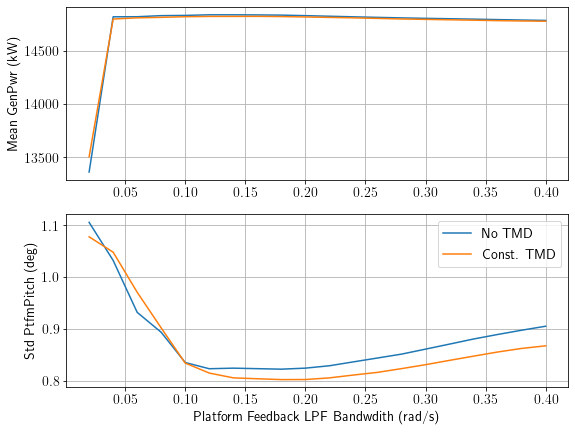

In [54]:
ss_channels = [
               ('GenPwr','mean'),
#                ('GenPwr','max'),
#                ('GenSpeed','max'),
#                ('TwrBsMyt','max'),
#                ('TwrBsMyt','std'),
#                ('TwrBsMxt','std'),
               ('PtfmPitch','std'),
#                ('PtfmRoll','std'),
#                ('PtfmHeave','std'),
#                ('PtfmSurge','std'),
#                ('PtfmSway','std'),
#                ('PtfmYaw','std'),
#                ('NcIMUTAxs','std'), 
#                ('NcIMUTAys','std'), 
              ]


font = {'size'   : 14}

plt.rc('font', **font)

plt.rcParams["figure.figsize"] = [9,3.5 * len(ss_channels)]
fig, ax = plt.subplots(len(ss_channels),1)

for st_i in stp:
    for ichan, chan in enumerate(ss_channels):
        st_i[parameters[param_ind]]
#         ax[ichan].scatter(st_i[parameters[param_ind]].loc[indSel],st_i[chan[0],chan[1]].loc[indSel])
        if test_case in ['no_mass','const_wn','ideal_wn','controlled_wn','sweep_wn']:
            ax[ichan].scatter(st_i[parameters[param_ind]],st_i[chan[0],chan[1]])
        else:
            ax[ichan].plot(st_i[parameters[param_ind]],st_i[chan[0],chan[1]])
        ax[ichan].set_xlabel(parameters[param_ind][1])
        ax[ichan].set_ylabel(chan)
        ax[ichan].grid(True)
        
        if ichan < len(ss_channels)-1:
            ax[ichan].set_xlabel('')
        else:
            ax[ichan].set_xlabel('Platform Feedback LPF Bandwdith (rad/s)')
            
        if True:
            units = ['kW','deg','kNm']
            ax[ichan].set_ylabel(chan[1].capitalize() + ' ' + chan[0] + ' (' + units[ichan] + ')')

# Print Max Rot Thrust

# st_i[parameters[param_ind]].loc[indSel]
# parameters[param_ind]

# stp[1]
# ws

if True:
    plt.legend(('No TMD','Const. TMD'))
    save_dir = '/Users/dzalkind/Projects/NASA/Documents/Memo'
    
    plt.savefig(os.path.join(save_dir,test_case))
    
plt.show()

# test_dir   = ['/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100/ntm',
#               '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps080/ntm',
#              '/Users/dzalkind/Tools/WEIS-3/results/UMaine-Fixed/DISCON_fixed_ps100_const_pwr/ntm']

# Grouped Scatter Plots

In [24]:
# play/debugging

parameters

[('meta', 'ps_perc'),
 ('HydroDyn', 'TMDThere'),
 ('IEC', 'DLC'),
 ('meta', 'MeanWS'),
 ('TwrBsMyt', 'std'),
 ('PtfmPitch', 'std'),
 ('PtfmYaw', 'std')]

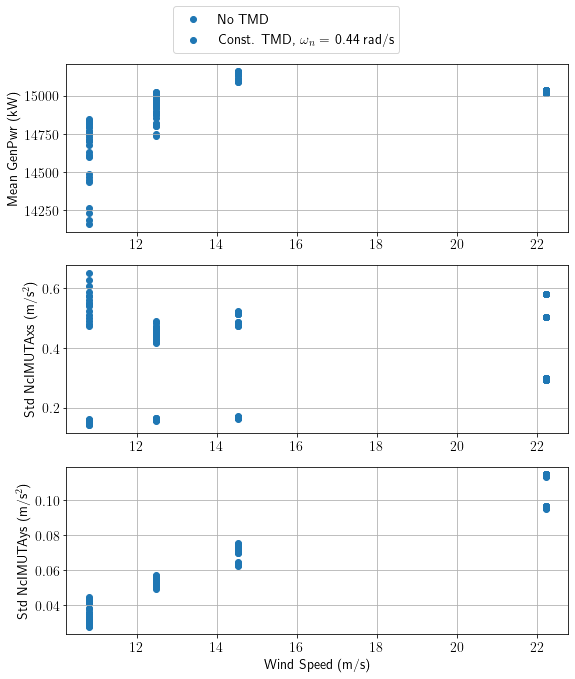

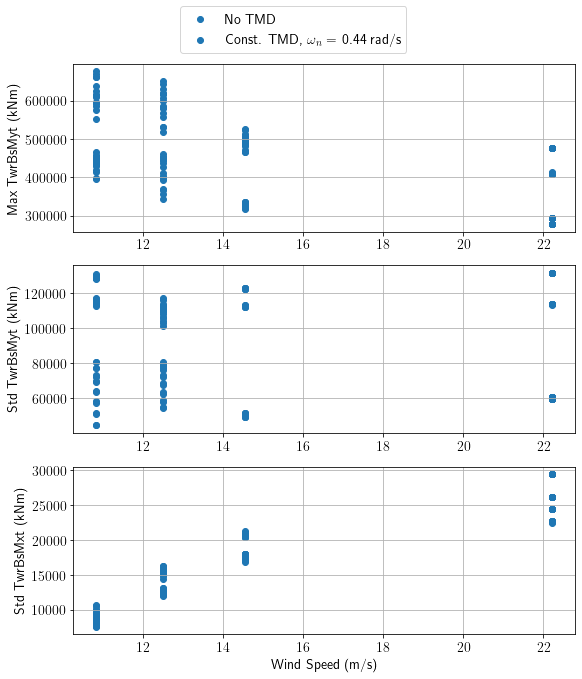

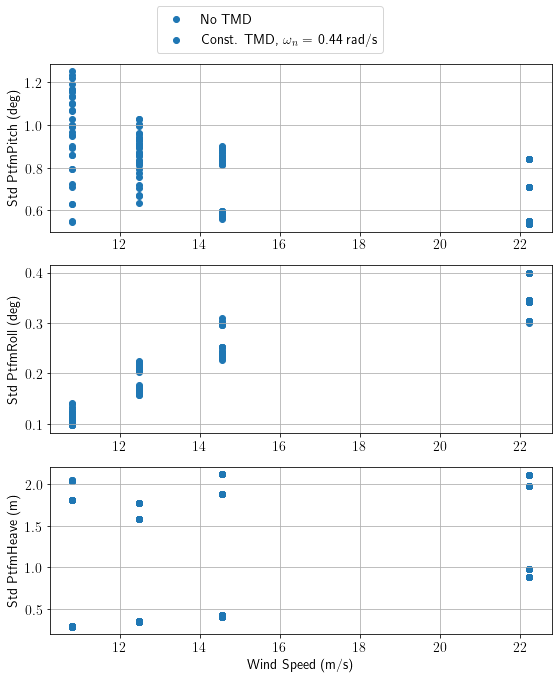

In [25]:
ss_channels = [
               [
               ('GenPwr','mean'),
               ('NcIMUTAxs','std'), 
               ('NcIMUTAys','std')
               ],
#                ('GenPwr','max'),
#                ('GenSpeed','max'),
               [
               ('TwrBsMyt','max'),
               ('TwrBsMyt','std'),
               ('TwrBsMxt','std'),
               ],
               [    
               ('PtfmPitch','std'),
               ('PtfmRoll','std'),
               ('PtfmHeave','std')
               ]
]


units = [['kW','m/s$^2$','m/s$^2$'],['kNm','kNm','kNm'],['deg','deg','m']]

plt.rcParams["figure.figsize"] = [9,3.5 * len(ss_channels[0])]
plt.rcParams['text.usetex'] = True
font = {'size'   : 14}

plt.rc('font', **font)
    
fig = [None] * len(ss_channels)
ax = [None] * len(ss_channels)

i = 0
for st_i, ws in zip(st,windspeeds):
    for iset, chan_set in enumerate(ss_channels):
        if not i:
            fig[iset], ax[iset] = plt.subplots(len(chan_set),1)
            
    
        for ichan, chan in enumerate(chan_set):     
            try:
                ax[iset][ichan].scatter(ws,st_i[chan[0],chan[1]])
            except:
                pass
            ax[iset][ichan].set_xlabel('Wind Speed (m/s)')
            ax[iset][ichan].set_ylabel(chan)
            ax[iset][ichan].grid(True)
            
            if ichan < len(chan_set)-1:
                ax[iset][ichan].set_xlabel('')
                 
            ax[iset][ichan].set_ylabel(chan[1].capitalize() + ' ' + chan[0] + ' (' + units[iset][ichan] + ')')
            
        fig[iset].legend(('No TMD','Const. TMD, $\omega_n$ = 0.44 rad/s'),loc=4,bbox_to_anchor=(0.65, .885))
            
        if False:  # Print!
            save_fig_dir = '/Users/dzalkind/Projects/NASA/Documents/Memo'
            fig[iset].savefig(os.path.join(save_fig_dir,test_case + chan[0]))
            
    i+=1


# Summary Plots
Bar plots by DLC

['No TMD', 'Const. TMD', 'Ideal TMD']


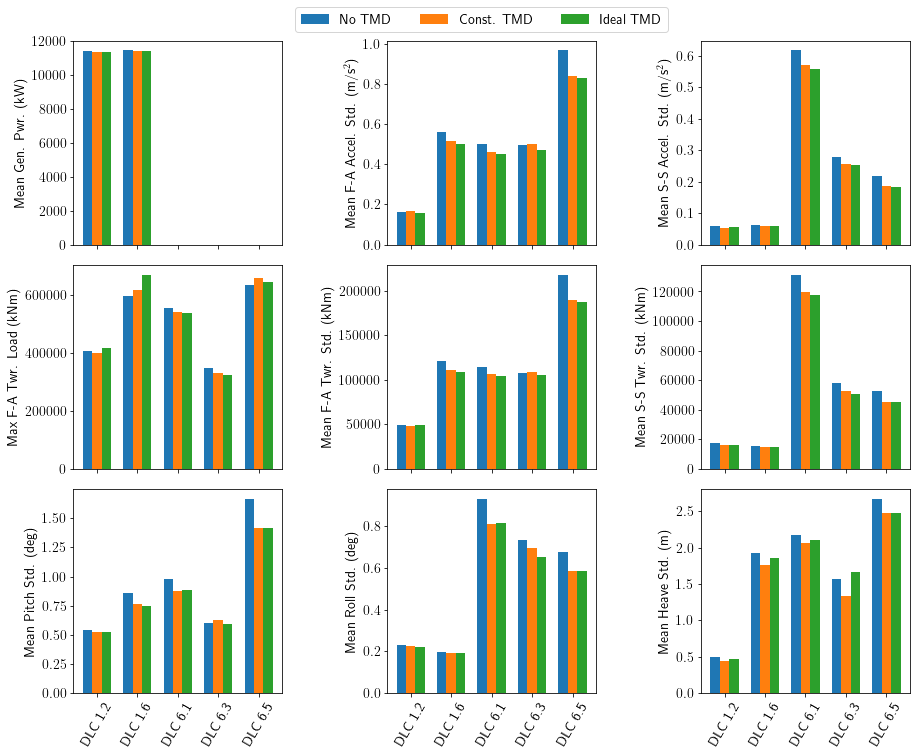

In [144]:
# Group by DLC and summarize
ss_channels = [
               ('mean','GenPwr','mean'),
               ('mean','NcIMUTAxs','std'), 
               ('mean','NcIMUTAys','std'),
               ('max','TwrBsMyt','max'),
               ('mean','TwrBsMyt','std'),
               ('mean','TwrBsMxt','std'),  
               ('mean','PtfmPitch','std'),
               ('mean','PtfmRoll','std'),
               ('mean','PtfmHeave','std')
]


units = ['kW','m/s$^2$','m/s$^2$','kNm','kNm','kNm','deg','deg','m']
y_labels = [
          'Mean Gen. Pwr.',
          'Mean F-A Accel. Std.',
          'Mean S-S Accel. Std.',
          'Max F-A Twr. Load',
          'Mean F-A Twr. Std.',
          'Mean S-S Twr. Std.',
          'Mean Pitch Std.',
          'Mean Roll Std.',
          'Mean Heave Std.'
         ]

y_labels = [yl + ' (' + un + ')' for yl, un in zip(y_labels,units)]

uniqueDLCs = st[0]['IEC','DLC'].unique()

sum_stats = np.zeros((len(ss_channels),len(st),len(uniqueDLCs)))

for iDLC, DLC in enumerate(uniqueDLCs):
    indDLC = st[0]['IEC','DLC'] == DLC
    
    for i_st, st_i in enumerate(st):
        for j_chan, chan in enumerate(ss_channels):
            if chan[0] == 'mean':
                sum_stats[j_chan][i_st][iDLC] = st_i[chan[1],chan[2]].loc[indDLC].mean()
            elif chan[0] == 'max':
                sum_stats[j_chan][i_st][iDLC] = st_i[chan[1],chan[2]].loc[indDLC].max()

if test_case == 'const_wn':
    TMD_Cases = ['No TMD','Const. TMD']
elif test_case == 'ideal_wn':
    TMD_Cases = ['No TMD','Const. TMD','Ideal TMD']
elif test_case == 'controlled_wn':
    TMD_Cases = ['No TMD','Const. TMD','Ideal TMD','Controlled TMD']
    
print(TMD_Cases)
    
labels = ['DLC '+ str(dlc) for dlc in uniqueDLCs]
x = np.arange(len(labels))
width = 0.7

plt.rcParams["figure.figsize"] = [15,12]

if len(st) == 2:
    offset = [-width/4,width/4]
elif len(st) == 3:
    offset = [-width/3,0,width/3]
elif len(st) == 4:
    offset = [-width*3/8,-width*1/8,width*1/8,width*3/8]

fig, ax = plt.subplots(3,3)
plt.subplots_adjust(wspace=0.5,hspace=0.1)

ax = ax.flatten()
i_ax = 0;
for i_chan, chan in enumerate(ss_channels):
    for i_ss, ss in enumerate(sum_stats[i_chan]):
#         sum_stats[i_chan][i_ss]
        sum_stats[i_chan][i_ss]
        ax[i_chan].bar(x + offset[i_ss],sum_stats[i_chan][i_ss],width/len(st),label=TMD_Cases[i_ss])
#         plt.grid()
#         ax[i_chan].set_xticklabels(labelrotation=45)
        
#         i_ax += 1
        
        ax[i_chan].set_ylabel(y_labels[i_chan])
        ax[i_chan].set_xticks(x)
        if i_chan > 5:
            ax[i_chan].set_xticklabels(labels, rotation=60)
        else:
            ax[i_chan].set_xticklabels('')
            
            
hl = plt.legend(ncol=len(st),loc='best', bbox_to_anchor=(-.625, 2.9, 0.5, 0.5))

        
    

# plt.setp((rotation=70)

# offset
# sum_stats[i_chan][i_ss]
# i_ss
# sum_stats[0]
# # uniqueDLCs
# plt.bar(x - width/2,sum_stats[0][0],width,label=TMD_Cases[0])
# plt.bar(x + width/2,sum_stats[0][1],width,label=TMD_Cases[0])
# # str(uniqueDLCs)

if True:
    plt.savefig(os.path.join(save_fig_dir,test_case + '.png'))
    
    
# plt.show()
# len(st)



In [147]:
sum_stats[8]

array([[0.49101159, 1.92953367, 2.17467047, 1.56171632, 2.66821911],
       [0.44676159, 1.75893437, 2.06591273, 1.33490865, 2.4701952 ],
       [0.46812923, 1.86287888, 2.10539607, 1.67051819, 2.47180267]])

# Wind/Wave Misalignment

In [ ]:
ind61  = st[0]['IEC','DLC'] == 6.1
param_ind = 2

parameters

In [ ]:
if test_case in ["no_mass",'const_wn']:
    ss_channels = [
                   [
                   ('TwrBsMyt','std'),
                   ('TwrBsMxt','std'), 
                   ('TwrBsM','std')
                   ],
    ]


    units = [['kNm','kNm','kNm'],['kNm','kNm','kNm'],['deg','deg','m']]

    plt.rcParams["figure.figsize"] = [9,3.5 * len(ss_channels[0])]
    plt.rcParams['text.usetex'] = True
    font = {'size'   : 14}

    plt.rc('font', **font)

    fig = [None] * len(ss_channels)
    ax = [None] * len(ss_channels)

    i = 0
    for st_i, ws in zip(st,windspeeds):
        for iset, chan_set in enumerate(ss_channels):
            if not i:
                fig[iset], ax[iset] = plt.subplots(len(chan_set),1)


            for ichan, chan in enumerate(chan_set):     
                try:
                    if not ichan:
                        ax[iset][ichan].scatter(st_i[parameters[param_ind]].loc[ind61],st_i[chan[0],chan[1]].loc[ind61])
                    else:
                        ax[iset][ichan].scatter(st_i[parameters[param_ind]].loc[ind61],st_i[chan[0],chan[1]].loc[ind61])
                except:
                    pass
                ax[iset][ichan].set_xlabel('Wave Direction (deg.)')
                ax[iset][ichan].set_ylabel(chan)
                ax[iset][ichan].grid(True)

                if ichan < len(chan_set)-1:
                    ax[iset][ichan].set_xlabel('')

                ax[iset][ichan].set_ylabel(chan[1].capitalize() + ' ' + chan[0] + ' (' + units[iset][ichan] + ')')

            fig[iset].legend(['No TMD','Const. TMD'],loc=4,bbox_to_anchor=(0.6, .885))

            if True:  # Print!
                save_fig_dir = '/Users/dzalkind/Projects/NASA/Documents/Memo'
                fig[iset].savefig(os.path.join(save_fig_dir,'wave_dir'))

        i+=1

# Review Load Ran

In [151]:
lr[1].TwrBsMyt.head(20)

,max,max_case_idx,std,std_case_idx
0,660322.736358,179,195191.794012,180
1,654065.196404,178,193565.438097,174
2,619861.278168,90,193027.084355,179
3,611012.341013,93,191812.180973,178
4,606762.676701,91,191293.323034,175
5,580709.398236,92,190928.059108,181
6,580293.989873,84,186742.372578,182
7,577497.627513,181,185062.959647,183
8,570564.477717,87,184719.246511,176
9,568219.863798,180,181111.455277,177


 # Plot Selected Cases

In [158]:
%matplotlib

Using matplotlib backend: MacOSX


In [162]:
# Select Case I.D.s
case_ids = [90,94]


plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'GenSpeed','TwrBsMyt','GenPwr']

case_outs = [outs[case_id] for outs in outfiles for case_id in case_ids]
# case_outs

for i_case, case in enumerate(case_ids):
    fastout = fast_io.load_fast_out(case_outs[i_case], tmin=200)

    # Plot
    fig, ax = fast_pl.plot_fast_out(cases, fastout, showplot=True)

#     legs = tuple([os.path.basename(test) for test in test_dir])
#     plt.legend(legs, loc='upper center', bbox_to_anchor=(
#                         0.5, 0.0), borderaxespad=2, ncol=2)


In [161]:
# test_dir = ['/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps080_const_pwr/simp',
#            '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp',
#            '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100/simp']

# fastout[0]
%matplotlib

Using matplotlib backend: MacOSX


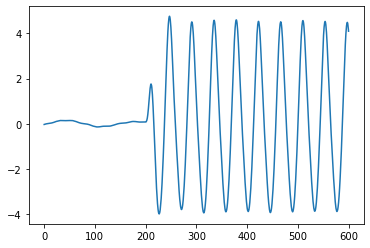

In [10]:
cont_out = '/Users/dzalkind/Tools/WEIS-3/results/CT-spar/DISCON_fixed_ps100_const_pwr/simp/step_0.RO.dbg'
rosco_out = fast_io.load_fast_out(cont_out, tmin=200)

rosco_out[0]

plt.plot(rosco_out[0]['Time'],180/3.14 * rosco_out[0]['Fl_Pitcom'])
plt.show()

# cases = {}
# cases['Floating Pitch Control'] = ['Fl_Pitcom']

# fig, ax = fast_pl.plot_fast_out(cases, rosco_out, showplot=False)

# Power Production
Min, Avg, and Max vs. Wind Speed

In [135]:
# unique_wind_speeds = np.unique(np.array(windspeeds)[indAEP])

# mean_gen_pwr = np.zeros(len(unique_wind_speeds))
# min_gen_pwr  = np.zeros(len(unique_wind_speeds))
# max_gen_pwr  = np.zeros(len(unique_wind_speeds))
# for i, ws in enumerate(unique_wind_speeds):
#     ws_ind = windspeeds == ws
#     mean_gen_pwr[i] = np.mean(st['GenPwr']['mean'][ws_ind])
#     min_gen_pwr[i]  = np.min(st['GenPwr']['min'][ws_ind])
#     max_gen_pwr[i]  = np.max(st['GenPwr']['max'][ws_ind])

# rated_power = fastRead.fst_vt['DISCON_in']['VS_RtPwr']

# # plot
# plt.figure(figsize=[8,6])
# plt.plot([3.,25.],rated_power*np.array([1.,1.])/1e3,linestyle='--',color='k',label='rated')
# plt.plot(unique_wind_speeds,mean_gen_pwr,linewidth=3,label='mean')
# plt.plot(unique_wind_speeds,min_gen_pwr,linewidth=1.5,color='r',label='min/max')
# plt.plot(unique_wind_speeds,max_gen_pwr,linewidth=1.5,color='r')

# plt.legend(fontsize=12,loc='lower right')
# plt.ylabel('Gen. Power (kW)',fontsize=14)
# plt.xlabel('Wind Speed (m/s)',fontsize=14)
# plt.show()

KeyError: 'GenPwr'

# Generator Speed
- List top k generator speed transients

In [16]:
k = 3
j = 2


cm_wind_speed = cm_wind[('InflowWind','WindSpeed')]
cm_dlc = cm_wind[('IEC','DLC')]
st_gen = st['GenSpeed']['max']

# cm_wind

max_df = pd.DataFrame(cm_dlc)
max_df[('WindSpeed','m/s')] = cm_wind_speed
max_df[('MaxGenSpeed','rpm')] = st_gen
max_df[('Max_TwrBsMyt','kNm')] = st['TwrBsMyt']['max']
max_df[('Max_RootMyb1','kNm')] = st['RootMyb1']['max']
max_df[('Max_RootMyb2','kNm')] = st['RootMyb2']['max']
max_df[('Max_RootMyb3','kNm')] = st['RootMyb3']['max']

max_gen_df = max_df.sort_values(('MaxGenSpeed','rpm'),ascending=False).head(k)
# max_gen_df[[('IEC','DLC'),('WindSpeed','m/s')]]

- Plot top j timeseries

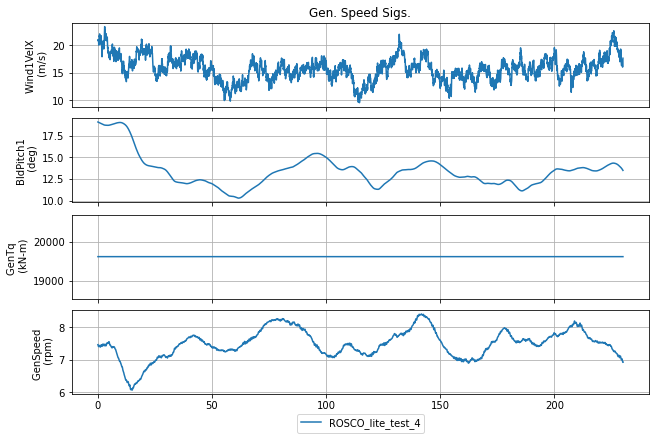

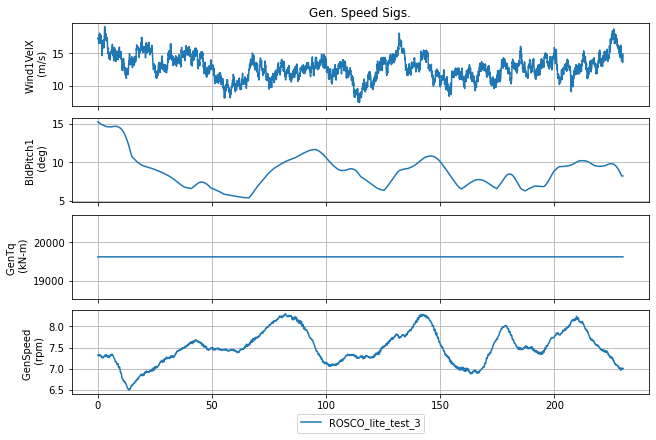

In [17]:
output_ext = '.outb'
plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
#  --- Comment,uncomment, create, and change these as desired...
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'GenSpeed']

outfiles = list(test_dir + os.path.sep + max_gen_df.index + output_ext)

for of in outfiles[0:j]:
    # Load output info and data
    fastout = fast_io.load_fast_out(of, tmin=100)
    
    # Plot
    fig = fast_pl.plot_fast_out(cases, fastout, showplot=False)
    

# Tower Loads
- List top k loads
- Plot top j cases

In [18]:
k = 3
j = 2


st_twr = st['TwrBsMyt']['max']

max_twr_df = pd.DataFrame(cm_dlc)
max_twr_df[('WindSpeed','m/s')] = cm_wind_speed
max_twr_df[('Max_TwrBsMyt','kNm')] = st_twr

max_twr_df = max_twr_df.sort_values(('Max_TwrBsMyt','kNm'),ascending=False).head(k)
max_twr_df

,IEC,WindSpeed,Max_TwrBsMyt
,DLC,m/s,kNm
Case_Name,,,
ROSCO_lite_test_3,1.1,14.0,380374.211137
ROSCO_lite_test_2,1.1,11.0,344697.799781
ROSCO_lite_test_4,1.1,17.0,311955.056061


- Plot top j timeseries

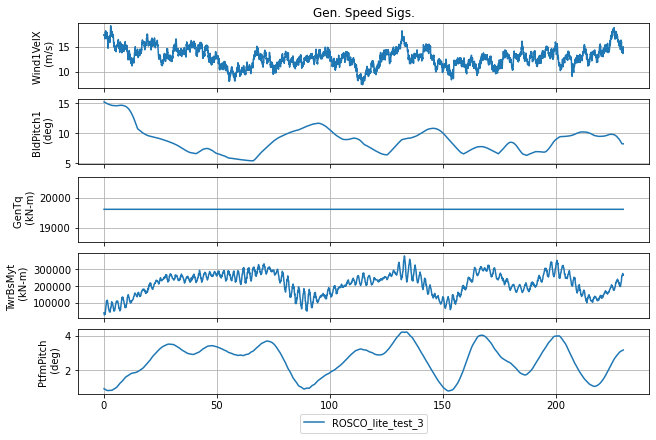

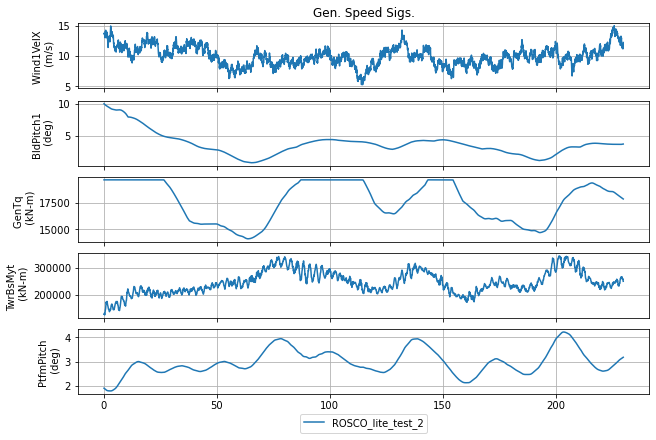

In [19]:
output_ext = '.outb'
plt.rcParams["figure.figsize"] = [9,6]

#  Define Plot cases 
#  --- Comment,uncomment, create, and change these as desired...
cases = {}
cases['Gen. Speed Sigs.'] = ['Wind1VelX', 'BldPitch1', 'GenTq', 'TwrBsMyt','PtfmPitch']

outfiles = list(test_dir + os.path.sep + max_twr_df.index + output_ext)

for of in outfiles[0:j]:
    # Load output info and data
    fastout = fast_io.load_fast_out(of, tmin=100)
    
    # Plot
    fig = fast_pl.plot_fast_out(cases, fastout, showplot=False)
    

In [83]:
# # Compare to results in compRunDir
# # Check these maxima
# caseMeasures    = ['RotSpeed',
#                     'RootMyb',
#                     'TwrBsMyt',
#                     'PtfmPitch']

# loadRanksThis   = Processing.load_yaml(os.path.join(fp.results_dir,'dataset1_LoadRanking.yaml'))

# # If no comparison exists, just print own stats
# try:
#     loadRanksComp   = Processing.load_yaml(os.path.join(compRunDir,turbine,'stats','dataset1_LoadRanking.yaml'))

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}\t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0],loadRanksComp[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))

# except:
#     print('No comparison files exist!')

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))
# windspeeds, seed, IECtype, cm_wind = Processing.get_windspeeds(cm, return_df=True)

# stats = FileTools.load_yaml(os.path.join(fp.results_dir,'dataset1_stats.yaml'))
# st = pdTools.dict2df(stats)

# pp = Analysis.Power_Production()
# Vavg = 10   # Average wind speed of cite
# Vrange = [2,26] # Range of wind speeds being considered
# indAEP = np.array(IECtype) == 'NTM'

# pp.windspeeds = np.sort(np.array(windspeeds)[indAEP])
# AEP = pp.AEP(st[indAEP],pp.windspeeds)
# RatedPower = fastRead.fst_vt['DISCON_in']['VS_RtPwr']
# print('Cap. Factor = {:3.3f}'.format(AEP/8760/RatedPower*1000))

# # Compare to results in compRunDir
# # Check these maxima
# caseMeasures    = ['RotSpeed',
#                     'RootMyb',
#                     'TwrBsMyt',
#                     'PtfmPitch']

# loadRanksThis   = Processing.load_yaml(os.path.join(fp.results_dir,'dataset1_LoadRanking.yaml'))

# # If no comparison exists, just print own stats
# try:
#     loadRanksComp   = Processing.load_yaml(os.path.join(compRunDir,turbine,'stats','dataset1_LoadRanking.yaml'))

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}\t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0],loadRanksComp[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))

# except:
#     print('No comparison files exist!')

#     print('\t\t{}'.format(turbine))
#     print('----------------------------------------')
#     print('\t\t{}\t{}'.format('This Control','Baseline'))
#     for meas in caseMeasures:
#         try:
#             print('Max {} \t{:1.3e}'.format(meas,loadRanksThis[meas]['max'][0]))
#         except:
#             print('{} is not in stats'.format(meas))